# Notebook 4: Blitztein and Diaconis (2011) Network Simulation
#### Econometric Methods for Networks
#### _CORE/UCL, December 12th to 14th, 2016_
##### _Bryan S. Graham, UC - Berkeley, bgraham@econ.berkeley.edu_
<br>
<br>
This is the fourth in a series of iPython Jupyter notebooks designed to accompany a series of instructional lectures given at CORE/UCL from December 12th to 14th, 2016. The scripts below were written for Python 2.7.12. The Anaconda distribution of Python, available at https://www.continuum.io/downloads, comes bundled with most the scientific computing packages used in these notebooks.
<br>
<br>
For more information about the course please visit my webpage at http://bryangraham.github.io/econometrics/.
<br>
<br>
This notebook provides an implement of the Blitztein and Diaconis (2011) method for constucting uniform random draws from the set of all adjacency matrices with fixed degree sequences. I am grateful to Seongjoo Min at UC Berkeley for drafting the code included here. This code, in turn, was derived by an R implementation by Joseph Blitztein available at http://www.people.fas.harvard.edu/~blitz/Site/Research_files/GraphAlgorithmR.txt.

In [8]:
# Direct Python to plot all figures inline (i.e., not in a separate window)
%matplotlib inline

# Importing necessary modules
import time
import numpy as np
import copy
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs

# Division of two integers in Python 2.7 does not return a floating point result. The default is to round down 
# to the nearest integer. The following piece of code changes the default.
from __future__ import division

In [9]:
# Directory where graphics files will be saved
graphics = '/Users/bgraham/Dropbox/Teaching/Short_Courses/CORE_Winter_School/Lectures/'

This first snippet of code defines all the functions needed to implement the Blitzstein and Diaconis (2011) proceedure. As noted above this code follows that of Joseph Blitzstein closely. It could, and should, be optimized for speed and scalability in various ways.

In [13]:
#-----------------------------------------------#
#- This function computes the corrected Durfee -#
#- number of a degree sequence. This is used   -#
#- to determined whether such a sequence is    -#
#- graphical.                                  -#
#-----------------------------------------------#

def durfee(degrees):
    
    if N==1:
        return 1
        
    durfeeLB = 1
    durfeeUB = N
    
    m = int(np.floor((N+1)/2))
    
    while (durfeeLB<durfeeUB-1):
        
        if degrees[m-1]>=m-1:
            durfeeLB = m         
        else:
            durfeeUB = m-1
            
        m = int(np.floor((durfeeLB+durfeeUB)/2))
        
    if degrees[m]>=m:
        m = m+1
        
    return m
    
#-------------------------------------------------#
#- This function tests whether a degree sequence -#
#- is graphical using the Erodos-Gallai Theorem  -#
#-------------------------------------------------#

def isGraphical(degrees):   
    
    if max(degrees)>=N:
        return False     
        
    if (sum(degrees) %2)==1:               # Check to see if sum of 
        return False                       # Sequence is even
        
    dsorted = sorted(degrees,reverse=True) # Sort degrees to descending order
    
    if dsorted[N-1]<0:                     # Smallest degree can't be negative!
        return False
        
    m = durfee(dsorted)                    # Get Durfee number
    
    minflips = [0]*N # This creates a length-N list of zeros
                     # The first element of this list, minflips[0], 
                     # equals N if dsorted[N-1], the smallest
                     # degree in the network, is positive.
    
    if dsorted[N-1]>0:
        for j in range(0,dsorted[N-1]):
            minflips[j] = N 
    
    # Loop over all agents in the network.
    # Recall that degrees are sorted in descending order.
    # Hence dsorted[0] gives the largest degree in the network.
    # If dsorted[N-1-i] > dsorted[N-i], then set minflips[N-i] = N-i
    for i in range(1,N):
        if dsorted[N-1-i]>dsorted[N-i]:
            for j in range(dsorted[N-i],dsorted[N-i-1]):
                minflips[j] = N-i
                
    partialsums = [dsorted[0]]
    
    for i in range(1,N):
        partialsums = partialsums+[partialsums[i-1]+dsorted[i]]
        
    for k in range(1,m+1):
        t = max(0,(minflips[k-1]-k)) # t is the number of degrees >= k
                                     # with indices >= k+1
        if partialsums[k-1]>(k*(k-1)+k*t+max(0,(partialsums[N-1]-partialsums[k+t-1]))):
            return False
            
    return True

#-----------------------------------------#
#- Tests whether an edge x appears among -#
#- a given list of edges.                -#
#-----------------------------------------#

def isEdge(x, edges):
    
    edges = np.matrix(edges)
    m = edges.shape[0] # Number of rows in edges
    
    if m==0:
        return False
        
    for i in range(0,m):
        if (edges[i,0]==x[0] and edges[i,1]==x[1]) or (edges[i,0]==x[1] and edges[i,1]==x[0]): 
            return True
            
    return False
    
#--------------------------------------------#
#- Tests whether a degree sequence, d, with -# 
#- the ith and jth elements subtracted by 1 -#
#- is itself graphical.                     -#
#--------------------------------------------#

def subtractGraphical(degrees, i, j):
    
    dtest = copy.copy(degrees)
    dtest[i] = dtest[i]-1
    dtest[j] = dtest[j]-1
    
    return isGraphical(dtest)
    
#----------------------------------------------#
#- Constructs a list of candidate vertices to -#
#- which an agent may be connected.           -#
#----------------------------------------------#

def listCandidates(vertex, degrees, edges):
    
    if (isGraphical(degrees)==False):
        return "Error: Non-graphical input in listCandidates"
        
    candidates = []
    
    for j in range(0,N):
        
        if (vertex!=j) and subtractGraphical(degrees, vertex, j)\
            and (isEdge([vertex,j], edges)==False):
            candidates = candidates+[j]
            
    return candidates
 
#----------------------------------------------#   
#- Add a new edge at random from the allowable-#
#- list.                                       #
#----------------------------------------------#   
   
def connectVertex(vertex, degrees, edges):
    
    cand    = listCandidates(vertex,degrees,edges)
    numCand = len(cand)
    
    if numCand==0:
        return "Error: No candidates"
        
    candDegrees = [0]*numCand
    
    for i in range(0,numCand):
        candDegrees[i] = degrees[cand[i]]
        
    candDegrees  = np.array(candDegrees).astype(float)
    p            = (candDegrees/np.sum(candDegrees))
    j            = np.random.choice(list(xrange(0,numCand)),1,False,p)
    w            = cand[j]
    dnew         = copy.copy(degrees)
    dnew[w]      = dnew[w]-1
    dnew[vertex] = dnew[vertex]-1
    edgesnew     = np.vstack((edges,[vertex,w]))
    
    return {'new_edge'         : [vertex,w],  'prob'         : (candDegrees[j]/np.sum(candDegrees)),\
            'new_degrees'      : dnew,        'candidates'   : cand, \
            'candidateDegrees' : candDegrees, 'new_edgelist' : edgesnew}
  
#--------------------------------------------#
#- Adds edges to a vertex until is residual -#
#- degree is zero.                          -#
#--------------------------------------------#
     
def connectVertexCompletely(vertex, degrees, edges):
    
    q        = connectVertex(vertex, degrees, edges)
    dnew     = q['new_degrees']
    seqProb  = q['prob']
    edgesnew = q['new_edgelist']
    
    while dnew[vertex]>0:
        q        = connectVertex(vertex, dnew, edgesnew)
        seqProb  = seqProb*q['prob']
        dnew     = q['new_degrees']
        edgesnew = q['new_edgelist']
        
    return {'sequentialProb': seqProb,'new_degrees' : dnew, \
            'new_edgelist'  : edgesnew}

#--------------------------------------------#
#- Find agent with smallest positive degree -#
#--------------------------------------------#
    
def indexSmallestNonzero(degrees):
    
    m = 0
    
    for i in range(1,N):
        
        if (degrees[m] == 0) or ((degrees[i] != 0) and degrees[i] < degrees[m]):
            m = i
            
    return m


#----------------------------------------------#
#- Construct adjacency matrix from the output -#
#- returned by generateGraphs()               -#
#----------------------------------------------#

def generateAdjs(result):
    
    mat = np.zeros((trials,N,N),dtype=int)
    
    for i in range(0,trials):
        graphs   = result['graphs'][i]
        numEdges = len(graphs)
        
        for k in range(0,numEdges):
            mat[i,graphs[k,0],graphs[k,1]] = 1
            mat[i,graphs[k,1],graphs[k,0]] = 1
        
    return mat
        
#----------------------------------------------------#
#- Generate random graph with given degree sequence -#
#----------------------------------------------------#

def generateRandomGraph(degrees):

    if isGraphical(degrees)==False:
        return "Error: Non-graphical input in generateRandomGraph"
    
    degrees = copy.copy(degrees)
    seqProb = 1
    orders  = 1
    edges   = np.matrix([0,0])
    edges   = np.delete(edges,0,axis=0)
    v       = indexSmallestNonzero(degrees)
    vv      = degrees[v]
   
    while vv>0:
        orders  = orders*np.math.factorial(vv)
        q       = connectVertexCompletely(v,degrees,edges)
        seqProb = seqProb*q['sequentialProb']
        degrees = q['new_degrees']
        edges   = q['new_edgelist']
        v       = indexSmallestNonzero(degrees)
        vv      = degrees[v]
       
    seqProb = max(seqProb,minSeqProb)
   
    return {'N'         : N,     'degrees' : degrees,               'sequentialProb' : seqProb, \
            'numOrders' : orders,'weight'  : (1./(seqProb*orders)), 'edges'          : edges}


#--------------------------------------------------------#
#- Generates random graphs with degree sequence d and   -# 
#- combines the results with importance weights to      -#
#- estimate the number of graphs with degree sequence d -#
#--------------------------------------------------------#  
def generateGraphs(degrees):
    
    weights = [0]*trials
    graphs = {}
    
    for i in range(0,trials):
        
        start = time.time()
        
        q = generateRandomGraph(degrees)
        weights[i] = q['weight']
        graphs[i] = q['edges']
        
        end = time.time()
        if (i+1) % 5 == 0:
            print "Time required simulation  " + str(i+1) + " of " + str(trials) + ": " + str(end-start)
        
    graphResults={'degrees'                  : degrees, 'weights' : weights, 'graphs' : graphs, \
                  'estimatedNumRealizations' : (1./trials)*np.sum(weights), \
                  'estimatedStardardError'   : (1./np.sqrt(trials))*np.std(weights)}
        
    return graphResults


#-------------------------------------------------#
# Computes triad census from an adjacency matrix -#
#-------------------------------------------------#

def triadCensus(adjM):
    
    adjM_new = np.matrix(adjM)
    tri      = np.trace(adjM_new**3)/6
    two      = (np.sum(adjM_new**2) - np.trace(adjM_new**2))/2 - 3*tri
    one      = (N-2)*np.sum(adjM_new)/2-2*two-3*tri
    emp      = N*(N-1)*(N-2)/6 - tri - two - one
    
    return [emp, one, two, tri]


Next load the Nyakatoke adjacency matrix from GitHub.

In [14]:
# Load Nyakatoke Adjacency matrix (sparse matrix file created in Notebook #1)
from scipy import io

# Location of saved adjacency matrix
adj_location = '/Users/bgraham/Dropbox/Teaching/Short_Courses/St_Gallen/Data/Created/' 

# Load matrix and convert to numpy 2d array
NyakatokeTestDataset = io.mmread(adj_location+"Nyakatoke_Adjacency.mtx")
Nyakatoke_adjM = NyakatokeTestDataset.toarray()

This final snippet of code draws B networks from the set of all networks with degree sequences coinciding with the one observed in Nyakatoke. It computes the triad census in each sampled network as well as the transivity index.

/Users/bgraham/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:156: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Time required simulation  5 of 200: 30.190502882
Time required simulation  10 of 200: 28.3602890968
Time required simulation  15 of 200: 30.7638320923
Time required simulation  20 of 200: 28.9906611443
Time required simulation  25 of 200: 29.465364933
Time required simulation  30 of 200: 28.6944069862
Time required simulation  35 of 200: 27.8211591244
Time required simulation  40 of 200: 28.0916519165
Time required simulation  45 of 200: 28.3592340946
Time required simulation  50 of 200: 27.4089989662
Time required simulation  55 of 200: 27.6480059624
Time required simulation  60 of 200: 27.8850610256
Time required simulation  65 of 200: 27.2368979454
Time required simulation  70 of 200: 27.024463892
Time required simulation  75 of 200: 27.4856271744
Time required simulation  80 of 200: 27.4483180046
Time required simulation  85 of 200: 27.9735920429
Time required simulation  90 of 200: 27.3862860203
Time required simulation  95 of 200: 27.3011579514
Time required simulation  100 of 20

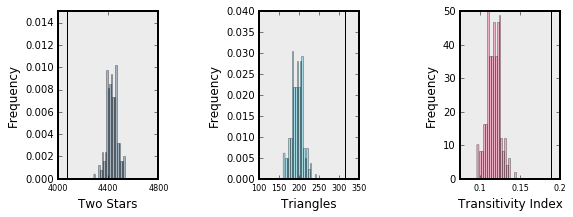

In [15]:
# Calculate degree sequence of Nyakatoke network
Nyakatoke_degrees = list(np.sum(Nyakatoke_adjM, axis=0, dtype=int))

#------------------------------------------------#
#- Draw B networks at random from reference set -#
#------------------------------------------------#

# Specifying global variables

N          = len(Nyakatoke_degrees)
trials     = 200
minSeqProb = 0.1**323 # This sets the minimum sequential probability for a
                      # random graph. Done to avoid underflow errors.
                      # NOTE: 0.1**323 is the maximal precision Python allows.


# Generate random adjacency matrices
graph_result = generateGraphs(Nyakatoke_degrees) 
adj_result   = generateAdjs(graph_result)

print("Completed simulation of reference graphs")

#-------------------------------------#
#- Triad Census & Transitivity Index -#
#-------------------------------------#

#  Triad census of the actual Nyakatoke data
Nyakatoke_triads = triadCensus(Nyakatoke_adjM)
Nyakatoke_TI     = 3*Nyakatoke_triads[3] / (Nyakatoke_triads[2] + 3*Nyakatoke_triads[3])


# Generating lists of triad census using the generated adjacency matrices
r_tri = np.zeros((trials),dtype=int)
r_two = np.zeros((trials),dtype=int)
r_one = np.zeros((trials),dtype=int)
r_emp = np.zeros((trials),dtype=int)
r_TI  = np.zeros((trials),dtype=float)

for i in range(0,trials):
    q = triadCensus(adj_result[i,:,:])
    r_emp[i] = q[0]
    r_one[i] = q[1]
    r_two[i] = q[2]
    r_tri[i] = q[3]
    r_TI[i]  = ((3*q[3]) / (q[2] + 3*q[3]))

#-------------------------------------#
#- Histogram                         -#
#-------------------------------------#

# Define figure object
exact_test_fig, sbp = plt.subplots(ncols=3, figsize=(9, 3))
ax1 = sbp[0] # Handle for left subplot
ax2 = sbp[1] # Handle for middle subplot
ax3 = sbp[2] # Handle for right subplot

# Plot 1: Histogram of two star triads
plt.axes(ax1) # Select first subplot
plt.hist(r_two, bins=20, normed=True, facecolor='#003262', alpha=0.3)
plt.plot((Nyakatoke_triads[2], Nyakatoke_triads[2]), (0, 1), 'k-') # plot vertical line at x = # two stars in Nyakatoke

# Set axis limits 
plt.ylim([0,0.015])
plt.xlim([4000,4800])  

# Set tick labels
tick_locs = [4000, 4400, 4800]
tick_lbls = [4000, 4400, 4800]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Two Stars", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax1.patch.set_facecolor('gray')               # Color of background
ax1.patch.set_alpha(0.15)                     # Translucency of background
ax1.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax1.spines[spine].set_visible(True)
    ax1.spines[spine].set_color('k')
    ax1.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=1)

# Plot 2: Histogram of triangle triads
plt.axes(ax2) # Select second subplot
plt.hist(r_tri, bins=20, normed=True, facecolor='#00B0DA', alpha=0.3)
plt.plot((Nyakatoke_triads[3], Nyakatoke_triads[3]), (0, 1), 'k-') # plot vertical line at x = # triangles in Nyakatoke

# Set axis limits 
plt.ylim([0,0.04])
plt.xlim([100,300])  

# Set tick labels
tick_locs = [100, 150, 200, 250, 300, 350]
tick_lbls = [100, 150, 200, 250, 300, 350]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Triangles", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax2.patch.set_facecolor('gray')               # Color of background
ax2.patch.set_alpha(0.15)                     # Translucency of background
ax2.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax2.spines[spine].set_visible(True)
    ax2.spines[spine].set_color('k')
    ax2.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=1)

# Plot 3: Histogram of transitivity index
plt.axes(ax3) # Select third subplot
plt.hist(r_TI, bins=20, normed=True, facecolor='#EE1F60', alpha=0.3)
plt.plot((Nyakatoke_TI, Nyakatoke_TI), (0, 100), 'k-')      # plot vertical line at x = transitivity index in Nyakatoke

# Set axis limits 
plt.ylim([0,60])
plt.xlim([0.075,0.2])  

# Set tick labels
tick_locs = [0.10, 0.15, 0.20]
tick_lbls = [0.10, 0.15, 0.20]
plt.xticks(tick_locs, tick_lbls, fontsize=8)

# Add axis labels
plt.xlabel("Transitivity Index", fontsize=12)   
plt.ylabel("Density", fontsize=12)

# Clean up the plot, add frames etc.
ax3.patch.set_facecolor('gray')               # Color of background
ax3.patch.set_alpha(0.15)                     # Translucency of background
ax3.grid(False)                               # Remove gridlines from plot

# Add frame around plot
for spine in ['left','right','top','bottom']:
    ax3.spines[spine].set_visible(True)
    ax3.spines[spine].set_color('k')
    ax3.spines[spine].set_linewidth(2)
    
# Tweak spacing between subplots to prevent labels from overlapping
plt.subplots_adjust(wspace=1)

# Save figure
plt.savefig(graphics+'Triad_Census_%d_Trials.png' %trials, bbox_inches='tight', dpi=500) 

In [16]:
# This imports an attractive notebook format
from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())